# Estudando nossa atmosfera com Python

Incolor, de constituintes invisíveis e inodoro (espera-se!). Por vezes nos esquecemos que estamos rodeados de gases que constituem nossa atmosfera. Nesse artigo, vamos ver como podemos facilmente, com a linguagem Python, conseguir uma listagem dos principais constituintes do ar com web scrapping. E, também, fazer algumas contas como, por exemplo, de densidade e de massa molar média e, claro, apresentar tudo em gráficos espetaculares.

Vamos fazer uma pequena lista de ferramentas que utilizaremos aqui:

- Pint
- Chempy
- SciPy
- Pandas
- Web scraping com Pandas
- Expressões regulares
- Matplotlib
    - estilos prontos
    - escala de cores
    - scatter plot
    - personalização avançada de gráficos
- Python padrão
    - map
    - funções anônimas (lambda)
    - list comprehensions

Muita coisa útil, então vamos lá.

Em física, química ou matérias ligadas ao estudo das engenharias é comum aparecerem situações onde precisamos fazer contas que dependem de características do ar. Pode ser, por exemplo, uma reação química de combustão acontecendo a ar aberto onde precisamos considerar uma determinada porcentagem de oxigênio no ar ou a situação de um compressor onde precisamos saber qual a massa de ar que ele comporta numa determinada condição. Independente da situação, usualmente precisamos da densidade do ar ou da massa molar média do mesmo. Na realidade, tais quantidades estão intimamente relacionadas, como veremos.


## Setup inicial

Para começar, vamos importar algumas bibliotecas que usaremos. No decorrer do artigo será detalhado o papel de cada uma. A `pint` já apareceu em outros artigos aqui do site, você pode [ler mais sobre ela aqui](https://cienciaprogramada.com.br/2020/09/python-unidades-cerveja-pint/).

In [1]:
from scipy.constants import gas_constant
import matplotlib.pyplot as plt
import pint
import chempy
import pandas as pd

Vamos criar um registro de unidades e um criador de quantidades do `pint` e, também, configurar o pacote para trabalhar com gráficos criados via `matplotlib`.

In [2]:
ureg = pint.UnitRegistry()
ureg.setup_matplotlib(True)
Q_ = ureg.Quantity

## Embasamento teórico e obtendo dados químicos

Agora vamos conhecer um pouco o pacote `chempy`, cujo [site do projeto é este](https://github.com/bjodah/chempy). Com o `chempy` podemos facilmente obter informações de um composto a partir de sua fórmula. Vamos começar utilizando o gás hidrogênio como exemplo:

In [3]:
gas_hidrogenio = chempy.Substance.from_formula('H2')

O código acima, bem autoexplicativo, instancia uma substância `Substance` a partir da fórmula na forma de string.

Vamos olhar os atributos e métodos disponíveis publicamente no objeto `gas_hidrogenio` que criamos:

In [4]:
[x for x in dir(gas_hidrogenio) if not x.startswith('_')]

['attrs',
 'charge',
 'composition',
 'composition_keys',
 'data',
 'from_formula',
 'html_name',
 'latex_name',
 'mass',
 'molar_mass',
 'name',
 'unicode_name']

É interessante termos a opção de exportar a fórmula em formatos como LaTeX e unicode:

In [5]:
gas_hidrogenio.latex_name

'H_{2}'

In [6]:
gas_hidrogenio.unicode_name

'H₂'

Mas, para nossa finalidade aqui, o importante é termos o valor de massa molar. Podemos acessar de duas formas, através do atributo `mass` e do método `molar_mass`:

In [7]:
gas_hidrogenio.mass

2.016

In [8]:
gas_hidrogenio.molar_mass()

array(2.016) * g/mol

Como podemos perceber, o `mass` retorna um *float* adimensional, enquanto que `molar_mass` retorna com unidades. Podemos separar a magnitude da unidade caso desejado:

In [9]:
gas_hidrogenio.molar_mass().magnitude

array(2.016)

In [10]:
gas_hidrogenio.molar_mass().units

array(1.) * g/mol

Trabalhar com unidades é sempre desejável. No entanto, o `chempy` não utiliza o `pint` para gerenciar unidades e, sim, o [projeto quantities](https://github.com/python-quantities/python-quantities) que não é tão flexível quanto o `pint` e não integra muito bem com outros pacotes. Assim, neste artigo vamos trabalhar com o atributo `mass` e associar a ele uma unidade `pint`.

Quando trabalhamos com um gás, precisamos decidir qual modelo que será utilizado para descrever esse gás. A escolha do modelo depende do contexto. Se for um contexto onde uma grande exatidão é necessária ou próximo de condições pouco usuais (altíssima pressão, por exemplo), há [diversos modelos que podem ser utilizados](https://en.wikipedia.org/wiki/Real_gas), sendo o de [Van der Walls](https://en.wikipedia.org/wiki/Van_der_Waals_equation) provavelmente o mais conhecido. No nosso caso, o modelo simples de [gás ideal](https://en.wikipedia.org/wiki/Ideal_gas_law), que é ensinado no ensino médio em física e/ou química, é suficiente.

A equação dos gases ideais é:


$$
PV = nRT
$$

onde *P*, *V* e *T* são pressão, volume e temperatura; *n* é a quantidade de matéria; e *R* é a chamada constante dos gases ideais. Como quantidade de matéria de uma determinada substância é a massa da substância *m* dividida por sua massa molar *M*, podemos reescrever a equação como:

$$
PV = \frac{m}{M} RT
$$

Lembrando que densidade de um dado material é sua massa dividida por seu volume, podemos rearranjar a equação:

$$
\frac{m}{V} = \frac{PM}{RT} \therefore d = \frac{PM}{RT}
$$

Assim, vemos que há uma ligação entre a massa molar da substância com sua densidade.

A biblioteca `SciPy` fornece um grande conjunto de constantes. No início fizemos a importação da constante dos gases com a linha

```python
from scipy.constants import gas_constant
```

Vamos verificar o valor:

In [11]:
gas_constant

8.314462618

Conforme a [documentação da biblioteca](https://docs.scipy.org/doc/scipy/reference/constants.html), o valor da constante se encontra no Sistema Internacional de unidades (SI). Podemos associar a unidade ao valor com o criador de quantidades do `pint`, que instanciamos no início do artigo:

In [12]:
Q_(gas_constant, 'J/(mol K)')

8.314462618 <Unit('joule / kelvin / mole')>

Obviamente que você não precisaria importar o SciPy apenas para ter o valor dessa constante, poderia simplesmente colocar o valor numa variável no código e associar a unidade. Mas fiz isso aqui no artigo por dois motivos. O primeiro é informativo, mostrar que o [SciPy](https://scipy.org/), uma das bibliotecas científicas mais sensacionais, possui esse acervo de constantes. O segundo é mostrar a quantidade de significativos do valor que a biblioteca apresenta. Sobre isso vou escrever um pouco mais.

É uma (má) prática corriqueira em nosso sistema de ensino arredondar valores sem uma discussão mais detalhada das consequências disso. Assim, grandes erros acabam surgindo nas contas fruto dos arredondamentos feitos. Você que está lendo esse artigo até aqui certamente tem interesse na área científica então coloque uma coisa na cabeça: **o que tem que limitar a precisão de seus cálculos é a precisão de suas medições**. Toda medida tem uma incerteza associada. Mas essas constantes comuns em ciência, como a dos gases ideais ou a velocidade da luz, costumam passar por diversos métodos de determinação com elevada precisão, existindo inclusive o *Committee on Data of the International Science Council* (CODATA) que periodicamente publica [valores atualizados das principais constantes físicas](https://codata.org/initiatives/strategic-programme/fundamental-physical-constants/) das quais outras constantes podem ser derivadas. 

Caso tenha clicado no link, perceba a quantidade de algarismos significativos das constantes. É altamente provável que não será alguma dessas constantes que irá limitar a precisão de seus cálculos. Não adianta nada você, por exemplo, se esforçar para ter um valor de pressão que possa ser expresso com 4 significativos como, por exemplo, `1.200 Pa` mas arredondar a magnitude da constante dos gases para `8.31`. **Você jogou fora todo seu esforço experimental**. Utilize as constantes físicas com o máximo de significativos disponíveis. Cada arredondamento mal feito faz você perder um ano de vida (exagero para você lembrar da mensagem). 

Ah, e você pode estar achando estranho o valor apresentado para a constante dos gases. Talvez tenha pensado "*ué, não era 0,082?*" Sim, em outro sistema de unidades. O valor do SciPy está conforme o Sistema Internacional de Unidades (SI). No ensino médio e até mesmo em situações práticas usualmente utilizamos o valor mais adequado para trabalhar com as unidades atmosfera e litro. Veja a conversão:

In [13]:
Q_(gas_constant, 'J/(mol K)').to('atm l / (mol K)')

0.08205736607944732 <Unit('liter * standard_atmosphere / kelvin / mole')>

Novamente, atenção para os significativos do valor.

## A função que irá sustentar todo o trabalho

Bom, vamos voltar ao nosso gás ideal. Podemos criar uma função que calcule a densidade de um gás. De acordo com a equação que obtivemos acima, precisamos apenas da pressão, da massa molar e da temperatura. Mas, com a ajuda do `chempy` podemos obter a massa molar a partir da fórmula do gás. Logo, nossa função pode receber uma fórmula, a pressão e a temperatura. Podemos considerar valores padrão para a pressão e a temperatura, para condições ambiente, por exemplo:

In [14]:
def densidade_gas(formula, pressao=Q_('1 atm'), temperatura=Q_(25, 'degC')):
    """Calcula a densidade de um gás ideal"""
    
    R = Q_(gas_constant, 'J/(mol K)')
    M = chempy.Substance.from_formula(formula).mass
    M = Q_(M, 'g/mol')
    
    return (pressao * M/(R * temperatura.to('kelvin'))).to_base_units()

Os detalhes de uso do pacote `pint` podem ser [lidos aqui](https://cienciaprogramada.com.br/2020/09/python-unidades-cerveja-pint/).

Agora podemos passar uma fórmula e teremos a densidade para as condições de 1 atm e 25 °C.

In [15]:
densidade_gas('CO2')

1.7988258254712144 <Unit('kilogram / meter ** 3')>

Se quisermos outras condições, basta passar os parâmetros `pressao` e `temperatura`. Inclusive em qualquer unidade, já que o `pint` cuida da conversão internamente.

In [16]:
densidade_gas('CO2', pressao=Q_('1 * 10^4 Pa'), temperatura=Q_(0, 'degC'))

0.1937787323145848 <Unit('kilogram / meter ** 3')>

Ótimo, já temos como calcular a densidade de um gás. Mas e no caso da nossa atmosfera, que é um conjunto de gases?

## Web scraping com Pandas

Primeiro precisamos de uma fonte que nos dê os gases e suas quantidades relativas. [Esse link da Wikipedia](https://en.wikipedia.org/wiki/Atmosphere_of_Earth) possui uma tabela com essas informações. Vamos associar esse link a uma variável:

In [17]:
url = 'https://en.wikipedia.org/wiki/Atmosphere_of_Earth'

Agora vamos entender uma das importações que fizemos no início do artigo, a da biblioteca [Pandas](https://pandas.pydata.org/). Esta biblioteca é muito utilizada para análise e manipulação de dados e é excelente para dados que podem ser organizados em tabelas. Dentro do contexto do Pandas, um conjunto de dados tabelados é chamado de **DataFrame**.

O método `read_html` oferece uma lista de tabelas de uma URL na forma de objeto DataFrame:

In [18]:
len(pd.read_html(url))

13

Observe que foram encontrados 13 objetos que podem ser lidados como DataFrame no link. Você pode passar por cada um para ver qual é o de seu interesse. No nosso caso, é logo a primeira posição da lista, lembrando que estruturas de armazenamento em Python, como listas, começam em índice zero. Assim:

In [19]:
pd.read_html(url)[0]

Gas  \
                                                 Name   
0                                            Nitrogen   
1                                              Oxygen   
2                                               Argon   
3                  Carbon dioxide(April, 2020)(C)[13]   
4                                                Neon   
5                                              Helium   
6                                             Methane   
7                                             Krypton   
8               Not included in above dry atmosphere:   
9                                      Water vapor(D)   
10  notes: (A) volume fraction is equal to mole fr...   

                                                       \
                                              Formula   
0                                                  N2   
1                                                  O2   
2                                                  Ar   
3                                                 CO2   
4                                                  Ne   
5                                                  He   
6                                                 CH4   
7                                                  Kr   
8               Not included in above dry atmosphere:   
9                                                 H2O   
10  notes: (A) volume fraction is equal to mole fr...   

                                            Volume(A)  \
                                           in ppmv(B)   
0                                              780840   
1                                              209460   
2                                                9340   
3                                              413.61   
4                                               18.18   
5                                                5.24   
6                                                1.87   
7                                                1.14   
8               Not included in above dry atmosphere:   
9                                         0–30,000(D)   
10  notes: (A) volume fraction is equal to mole fr...   

                                                       
                                                 in %  
0                                              78.084  
1                                              20.946  
2                                              0.9340  
3                                            0.041361  
4                                            0.001818  
5                                            0.000524  
6                                            0.000187  
7                                            0.000114  
8               Not included in above dry atmosphere:  
9                                             0–3%(E)  
10  notes: (A) volume fraction is equal to mole fr...

A parte de notas sobre a tabela também foi reconhecida pelo Pandas como parte do objeto. Não é interesse nosso essa parte, então vamos retirar. Como essa parte começa a partir do índice 8 do DataFrame (o índice é a primeira coluna), vamos fazer um *slice* com `iloc`:

In [20]:
pd.read_html(url)[0].iloc[:8]

Gas          Volume(A)          
                                 Name Formula in ppmv(B)      in %
0                            Nitrogen      N2     780840    78.084
1                              Oxygen      O2     209460    20.946
2                               Argon      Ar       9340    0.9340
3  Carbon dioxide(April, 2020)(C)[13]     CO2     413.61  0.041361
4                                Neon      Ne      18.18  0.001818
5                              Helium      He       5.24  0.000524
6                             Methane     CH4       1.87  0.000187
7                             Krypton      Kr       1.14  0.000114

Será esse nosso DataFrame, vamos associar a uma variável:

In [21]:
df = _

É sempre interessante dar uma olhada em como o Pandas reconheceu os dados. Para isso temos os métodos `info` e `describe`:

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   (Gas, Name)              8 non-null      object
 1   (Gas, Formula)           8 non-null      object
 2   (Volume(A), in ppmv(B))  8 non-null      object
 3   (Volume(A), in %)        8 non-null      object
dtypes: object(4)
memory usage: 384.0+ bytes


In [23]:
df.describe()

Gas          Volume(A)          
            Name Formula in ppmv(B)      in %
count          8       8          8         8
unique         8       8          8         8
top     Nitrogen      Ne     209460  0.041361
freq           1       1          1         1

Observe que o Pandas reconheceu todas as colunas como sendo de tipo `object`. Esse tipo é genérico no Pandas. Usualmente, quando o algoritmo não reconhece exatamente o tipo, enquadra como `object`. Para todos os efeitos, os dados dessas colunas se comportam como strings. Isso fica claro no resultado de `describe` pois, se as colunas com números fosse reconhecidas como tais, apareceriam métricas como média, valor máximo e valor mínimo. Logo, uma das coisas que precisaremos fazer é converter a coluna de volume em porcentagem para o tipo correto, *float*, para que possamos utilizar os valores em nossas contas.

Outro aspecto que esses métodos nos permitem visualizar de forma mais clara é que há subcolunas ou, numa linguagem mais próxima a usada no contexto de Pandas, há multi-índices. Dentro do índice *Gas* há *Name* e *Formula*, e também há índices dentro de *Volume(A)*. Vamos ver como visualizar os valores da coluna *Formula*:

In [24]:
df['Gas']['Formula']

0     N2
1     O2
2     Ar
3    CO2
4     Ne
5     He
6    CH4
7     Kr
Name: Formula, dtype: object

Outra forma seria usando a notação do método `loc`:

In [25]:
df.loc[:, ('Gas', 'Formula')]

0     N2
1     O2
2     Ar
3    CO2
4     Ne
5     He
6    CH4
7     Kr
Name: (Gas, Formula), dtype: object

Podemos ver apenas os dados em *Volume(A)*, que são nossos dados numéricos:

In [26]:
df['Volume(A)']

,in ppmv(B),in %
0,780840,78.084
1,209460,20.946
2,9340,0.9340
3,413.61,0.041361
4,18.18,0.001818
5,5.24,0.000524
6,1.87,0.000187
7,1.14,0.000114


Agora vamos converter esses dados para o tipo `float`:

In [27]:
df['Volume(A)'] = df['Volume(A)'].astype(float)

In [28]:
df

Gas          Volume(A)           
                                 Name Formula in ppmv(B)       in %
0                            Nitrogen      N2  780840.00  78.084000
1                              Oxygen      O2  209460.00  20.946000
2                               Argon      Ar    9340.00   0.934000
3  Carbon dioxide(April, 2020)(C)[13]     CO2     413.61   0.041361
4                                Neon      Ne      18.18   0.001818
5                              Helium      He       5.24   0.000524
6                             Methane     CH4       1.87   0.000187
7                             Krypton      Kr       1.14   0.000114

Vamos agora nos preparar para criar uma coluna para a densidade de cada gás listado na subcoluna *Formula*. Vamos ver como seria o resultado de aplicar a função `densidade_gas` em cada fórmula usando a função `map` do Python:

In [29]:
list(map(densidade_gas, df['Gas']['Formula']))

[1.145045483304565 <Unit('kilogram / meter ** 3')>,
 1.3078876766894934 <Unit('kilogram / meter ** 3')>,
 1.6328363306579126 <Unit('kilogram / meter ** 3')>,
 1.7988258254712144 <Unit('kilogram / meter ** 3')>,
 0.8248259562876108 <Unit('kilogram / meter ** 3')>,
 0.1636025323611701 <Unit('kilogram / meter ** 3')>,
 0.6557422963038172 <Unit('kilogram / meter ** 3')>,
 3.4251631830497584 <Unit('kilogram / meter ** 3')>]

Observe que as unidades aparecem, já que nossa função utiliza o `pint`. Seria interessante ter apenas o valor numérico, usando o atributo `magnitude` de uma quantidade do `pint`, já que não faz sentido aparecer unidade em todas as linhas de uma tabela. Além de também facilitar nossa vida em cálculos futuros ter apenas números. Podemos criar uma função anônima para isso e aplicá-la com `map` no resultado anterior:

In [30]:
list( map(lambda quantidade: quantidade.magnitude, map(densidade_gas, df['Gas']['Formula'])) )

[1.145045483304565,
 1.3078876766894934,
 1.6328363306579126,
 1.7988258254712144,
 0.8248259562876108,
 0.1636025323611701,
 0.6557422963038172,
 3.4251631830497584]

Vamos armazenar o resultado anterior em uma coluna de nosso DataFrame:

In [31]:
df['density'] = _

In [32]:
df['density']

0    1.145045
1    1.307888
2    1.632836
3    1.798826
4    0.824826
5    0.163603
6    0.655742
7    3.425163
Name: density, dtype: float64

Relembrando nossas premissas, esses valores são a densidade de cada gás separadamente considerando um modelo de gás ideal, a pressão de 1 atm e a temperatura de 25 °C.

## Densidade e massa molar média do ar

Conforme explicado no link da Wikipedia de onde tiramos a tabela, os valores de porcentagem apresentados consideram ar seco, já que o teor de umidade varia muito mesmo em uma dada localidade. Assim, quando falamos de densidade do ar usualmente estamos nos referindo a densidade do ar seco. Essa densidade nada mais é que a média ponderada das densidades de cada constituinte do ar. Os pesoas são as porcentagens de cada constituinte. Assim:

In [33]:
densidade_ar_seco = sum([densidade_gas * porcentagem_gas for densidade_gas, porcentagem_gas in 
                         zip(df['density'], df['Volume(A)']['in %'])]) / sum(df['Volume(A)']['in %'])

In [34]:
densidade_ar_seco

1.1839683903282519

Esse é o valor calculado da densidade do ar seco. Considerando o número de significativos dos dados apresentados e colocando a devida unidade, é mais adequado representar o resultado como:

In [35]:
print(f"{Q_(densidade_ar_seco, 'kg/m^3'):.2~P}")

1.2 kg/m³


Seguindo a mesma linha de raciocínio, podemos calcular a massa molar média:

In [36]:
df['molar mass'] = [chempy.Substance.from_formula(formula).mass for formula in df['Gas']['Formula']]

massa_molar_media_ar_seco = sum([massa_molar_gas * porcentagem_gas for massa_molar_gas, porcentagem_gas in zip(df['molar mass'], df['Volume(A)']['in %'])]) / sum(df['Volume(A)']['in %'])

print(f"{Q_(massa_molar_media_ar_seco, 'g/mol'):.4~P}")

28.97 g/mol


## Gráficos! Eu quero imagens

Agora vamos usar todo o poder do Matplotlib para criar gráficos que facilitem a visualização da nossa análise e mesmo expanda ainda mais nossa compreensão.

O Pandas possui um método `plot` que é construído em cima do `plot` do Matplotlib. Podemos, por exemplo, criar facilmente um gráfico de barras com as densidades de cada gás do nosso DataFrame:

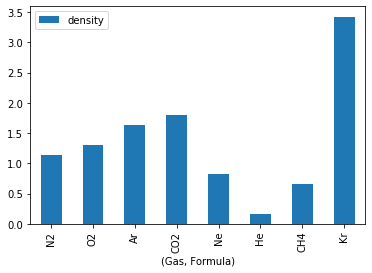

In [37]:
df.plot.bar(x=('Gas', 'Formula'), y='density')

As configurações padrão do Matplotlib são boas, mas há muito o que melhorar nesse gráfico. Afinal, falta mostrar a unidade no eixo vertical, títulos melhores nos eixos e os números nas fórmulas químicas deveriam estar em subscrito. Vamos resolver essas questões.

Para as fórmulas químicas, podemos criar uma função que, com auxílio de expressões regulares, retorna o código LaTeX necessário para apresentar as fórmulas corretamente. Isso porque o Matplotlib interage muito bem com LaTeX, o que é ótimo para nós da área de ciência que utilizamos muito em nossos trabalhos.

In [38]:
import re

def format_formula(formula):
        """ Retorna código LaTeX para apresentar fórmulas químicas corretamente"""
        
        label_formula = re.sub("([0-9])", r"_\1", formula)
        
        return ''.join(['$\mathregular{', label_formula, '}$'])

Basicamente a função acrescenta antes de qualquer dígito um `_` de forma que o código LaTeX passa a reconhecer o dígito como subscrito. Para entender mais sobre expressões regulares [leia esse excelente artigo aqui do site](https://cienciaprogramada.com.br/2020/09/regex-expressoes-regulares-python/).

O esquema de cores padrão do Matplotlib é bom e apresentável, mas particularmente gosto bastante de gráficos com fundo escuro. Assim, vou usar um dos [estilos prontos](https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html) que há na biblioteca:

In [39]:
plt.style.use('dark_background')

Agora vamos criar uma figura, associar a ela um sistema de eixos e colocar as informações que queríamos de unidade, nomes nos eixos, fórmulas químicas corretas e, para aproveitar, uma linha indicando a densidade do ar seco que calculamos anteriormente:

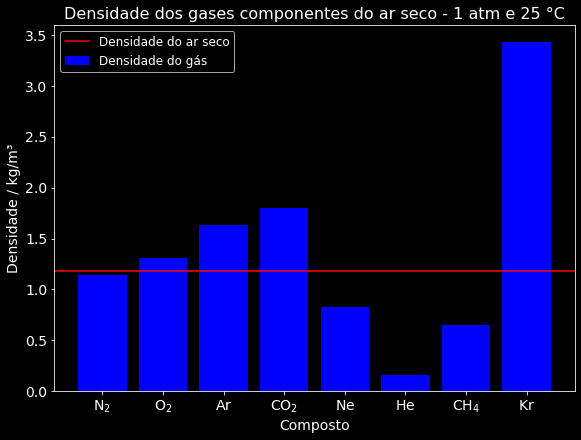

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6), constrained_layout=True)

# Dados
ax.bar(df['Gas']['Formula'], df['density'], color='blue', label='Densidade do gás')
ax.axhline(densidade_ar_seco, color='red', label='Densidade do ar seco')

# Fórmulas químicas certas
ax.set_xticklabels(list(map(format_formula, df['Gas']['Formula'])))

# Identificação
ax.set_xlabel('Composto', size=14)
ax.set_ylabel('Densidade / kg/m³', size=14)
ax.set_title('Densidade dos gases componentes do ar seco - 1 atm e 25 °C', size=16)
ax.legend(fontsize=12)

# Ajuste da fonte das escalas
ax.tick_params(labelsize=14)

plt.show()

Esse gráfico é interessante, mas ele não apresenta ao leitor informações o suficiente para que ele entenda porque a densidade do ar seco é muito mais próxima daquela do gás nitrogênio do que do gás criptônio. Obviamente que os mais atentos deduzirão que isso provavelmente ocorre por ter muito pouco criptônio na atmosfera, mas seria útil esse dado estar explícito no gráfico.

Além disso, se o público for mais acadêmico como, por exemplo, em uma aula, poderia estar no gráfico também alguma indicação de que a densidade de um dado gás é proporcional à sua massa molar. Assim, mais discussões poderiam ser feitas sobre modelos de gases e mesmo sobre outras consequências a depender do objetivo do instrutor.

Então, agora vamos fazer um gráfico mais ousado para terminar com chave de ouro esse artigo. Podemos criar uma escala de intensidade de cores para indicar a concentração de gás na atmosfera. Por exemplo, uma cor amarela fraca indicaria baixa concentração e uma vermelho forte, alta concentração. Um gráfico de barras nos limita um pouco, vamos mudar para um gráfico de pontos do tipo *scatter* (dispersão em português). Nesse tipo de gráfico, o tamanho do ponto, ou melhor círculo, pode ser associado a uma quantidade. Assim, vamos associar ao valor da massa molar para termos a informação adicional que desejamos.

Para a criação da escala de cores, precisaremos de dois métodos do Matplotlib que ainda não importamos:

In [41]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

Vamos, então, criar uma figura com sistema de eixos e fazer os ajustes necessários no nosso gráfico. Usaremos o mapa de cores `YlOrRd` do Matplotlib e normalizaremos as cores com base nos valores de porcentagem em volume. Assim, o gás que tiver a menor porcentagem terá a cor amarela mais clara e o que tiver a maior, cor vermelha escura. Com esses dados, utilizaremos métodos do Matplotlib para construir uma escala de cores. Usando o `chempy`, obteremos a massa molar de cada fórmula no DataFrame e associaremos os valores a área de cada círculo. O código a seguir faz todas essas etapas. Recomendo que rode o código em sua máquina e interaja com ele, modificando cada parte e vendo seus efeitos. Dá para aprender muita coisa de Matplotlib aqui.

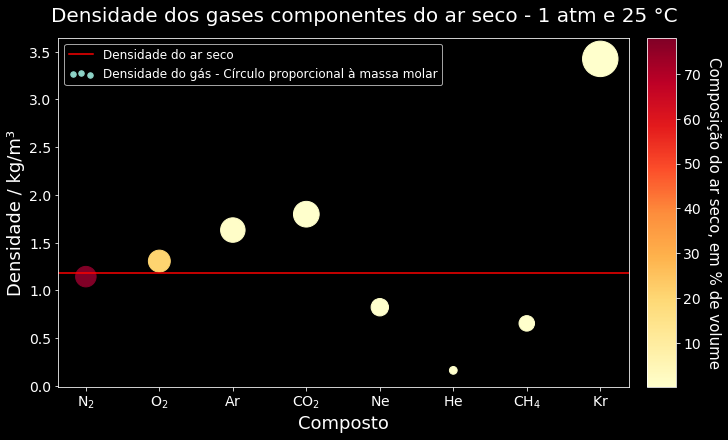

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6), constrained_layout=True)

# tamanho dos círculos com base na massa molar
raio_base = 15  # mude para ter círculos menores ou maiores
area_circulos = [chempy.Substance.from_formula(i).mass * raio_base for i in df['Gas']['Formula']]

# cores dos círculos com base nos valores de porcentagem em volume
cores_circulos = df['Volume(A)']['in %']
normalize = mcolors.Normalize(vmin=min(cores_circulos), vmax=max(cores_circulos))
colormap = cm.YlOrRd

# dados
sc = ax.scatter(df['Gas']['Formula'], df['density'], label='Densidade do gás - Círculo proporcional à massa molar', 
                s=area_circulos, c=cores_circulos, cmap=colormap)
ax.axhline(densidade_ar_seco, color='red', label='Densidade do ar seco')

# escala de cores
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(cores_circulos)
colorbar = fig.colorbar(scalarmappaple)

# Identificação
ax.set_xticklabels(list(map(format_formula, df['Gas']['Formula'])))
legenda = ax.legend(scatterpoints=3, fontsize=12)
legenda.legendHandles[1]._sizes = [30]
ax.set_xlabel('Composto', size=18)
ax.set_ylabel('Densidade / kg/m³', size=18)
colorbar.ax.set_ylabel('Composição do ar seco, em % de volume', rotation=270, labelpad=20, size=15)
fig.suptitle('Densidade dos gases componentes do ar seco - 1 atm e 25 °C', size=20)

# Ajuste da fonte das escalas
colorbar.ax.tick_params(labelsize=14)
ax.tick_params(labelsize=14)

plt.show()

Agora temos um gráfico muito rico em informações: densidade de cada gás isoladamente, densidade do ar seco, relação da densidade com a massa molar e composição percentual do ar. Tudo isso em apenas duas dimensões, o que é excelente para visualização estática. Gráficos em três dimensões são ótimos quando a pessoa pode interagir, rodando o mesmo, dando zoom. Mas em um material impresso ou online mas estático, pode ser um pouco confuso. Logo, colocar mais informações mantendo um gráfico bidimensional é uma melhor escolha.

## Conclusão. E um pedido...

E aí curtiu? Vamos fazer uma pequena lista de ferramentas que utilizamos aqui:

- Pint
- Chempy
- SciPy
- Pandas
- Web scraping com Pandas
- Expressões regulares
- Matplotlib
    - estilos prontos
    - escala de cores
    - scatter plot
    - personalização avançada de gráficos
- Python padrão
    - map
    - funções anônimas (lambda)
    - list comprehensions
    
Se você acha que esse artigo te ajudou, deixe um comentário e compartilhe em suas redes sociais. Isso ajuda muito esse projeto que está apenas começando a ser mais conhecido. É um pedido simples, mas que ajuda muito.


Por fim, caso tenha interesse em estudar mais nossa atmosfera, fica a dica do excelente livro [Introdução à Química da Atmosfera](https://amzn.to/3oRNPVK):

<a href="https://www.amazon.com.br/Introdu%C3%A7%C3%A3o-Qu%C3%ADmica-Atmosfera-Ci%C3%AAncia-Vida-Sobreviv%C3%AAncia/dp/8521634846/ref=as_li_ss_il?__mk_pt_BR=%C3%85M%C3%85%C5%BD%C3%95%C3%91&dchild=1&keywords=quimica+atmosfera&qid=1607965937&sr=8-1&linkCode=li3&tag=cienciaprogra-20&linkId=f694de05ca970f38a6302ec14c44cca4&language=pt_BR" target="_blank"><img border="0" src="//ws-na.amazon-adsystem.com/widgets/q?_encoding=UTF8&ASIN=8521634846&Format=_SL250_&ID=AsinImage&MarketPlace=BR&ServiceVersion=20070822&WS=1&tag=cienciaprogra-20&language=pt_BR" ></a><img src="https://ir-br.amazon-adsystem.com/e/ir?t=cienciaprogra-20&language=pt_BR&l=li3&o=33&a=8521634846" width="1" height="1" border="0" alt="" style="border:none !important; margin:0px !important;" />

Recentemente lançado em sua segunda edição, possui uma linguagem rigorosa, mas acessível, sendo uma grande fonte de informações a respeito de nossa atmosfera.

Até a próxima!